In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv


## Data Preparation

In [2]:
#Read file
df = pd.read_csv("FinalData.csv", encoding = 'ISO-8859-1')

In [3]:
#Convert to datetime
df['Date and Time of capture'] = pd.to_datetime(df['Date and Time of capture'])

In [4]:
#Drop unwanted columns
df = df.drop(["Measurement Description"], axis=1)
df = df.drop(["Parameter Type and Units"], axis=1)
df = df.drop(["Unnamed: 0"], axis=1)

In [5]:
#Drop Date to convert to datetime
df = df.drop(["Date"], axis=1)
df['Date'] = pd.to_datetime(df['Date and Time of capture']).dt.date
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
#Set Date and Time of capture as index and order data by index
df = df.set_index(df['Date and Time of capture'])
df = df.sort_index()

In [7]:
#Create 1 more time related variable - Day of month
df['DayOfMonth'] = df['Date and Time of capture'].dt.day

In [8]:
#Rename time column and separate time column into hour and minute columns
df.rename(columns={"Hour": "Time"})
df['Hour'] = df['Date and Time of capture'].dt.hour
df['Minutes'] = df['Date and Time of capture'].dt.minute

In [9]:
#Create datetime column where Date and Time of capture is integer 
df['datetime_int'] = pd.to_numeric(df['Date and Time of capture']) 

In [10]:
#Drop original Date and Time of capture as cannot be accepted by XGBoost
df = df.drop(["Date and Time of capture"], axis=1)

In [11]:
#Reset index
df = df.reset_index()

In [12]:
#Create minutes column
minutes = (df.Minutes + (df.Hour * 60))
df['Minutes'] = minutes

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date and Time of capture  17520 non-null  datetime64[ns]
 1   index                     17520 non-null  int64         
 2   Month                     17520 non-null  int64         
 3   Year                      17520 non-null  int64         
 4   Quarter                   17520 non-null  int64         
 5   DayOfWeek                 17520 non-null  object        
 6   Hour                      17520 non-null  int64         
 7   Season                    17472 non-null  object        
 8   Records                   17520 non-null  int64         
 9   Total Parameter           17520 non-null  float64       
 10  Date                      17520 non-null  datetime64[ns]
 11  DayOfMonth                17520 non-null  int64         
 12  Minutes           

In [14]:
# Get dummies for categorical variables
df = pd.get_dummies(df, prefix=['DayOfWeek', 'Season'], columns=['DayOfWeek', 'Season'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date and Time of capture  17520 non-null  datetime64[ns]
 1   index                     17520 non-null  int64         
 2   Month                     17520 non-null  int64         
 3   Year                      17520 non-null  int64         
 4   Quarter                   17520 non-null  int64         
 5   Hour                      17520 non-null  int64         
 6   Records                   17520 non-null  int64         
 7   Total Parameter           17520 non-null  float64       
 8   Date                      17520 non-null  datetime64[ns]
 9   DayOfMonth                17520 non-null  int64         
 10  Minutes                   17520 non-null  int64         
 11  datetime_int              17520 non-null  int64         
 12  DayOfWeek_Friday  

## Data Split

In [16]:
#Create dataframe with last day of dataset for day ahead prediction
dfprediction = df.loc[(df['Date'] == '2012-08-30')]

In [17]:
#Create dataframe where last day is dropped
df = df.drop(df[(df['Date'] == '2012-08-30')].index)

In [18]:
#Drop unwanted columns
df = df.drop(["Date"], axis=1)
dfprediction = dfprediction.drop(["Date"], axis=1)
df = df.drop(["Records"], axis=1)
dfprediction = dfprediction.drop(["Records"], axis=1)
df = df.drop(["index"], axis=1)
dfprediction = dfprediction.drop(["index"], axis=1)

In [19]:
#Split df up between train and test
#Last 6 months for testing
train, test= np.split(df, [int(.73 *len(df))])

In [20]:
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (12754, 20)
Test Dataset: (4718, 20)


In [21]:
#Test dataframe for day ahead prediction
daily_test = dfprediction["Total Parameter"]

# XGBoost

In [22]:
#Set up X and y train and test dataframes 
X_train = train.drop(columns= ["Date and Time of capture","Total Parameter"], axis=1)
X_test = test.drop(columns= ["Date and Time of capture","Total Parameter"], axis=1)
y_train = train["Total Parameter"]
y_test = test["Total Parameter"]

In [23]:
print('Train Dataset:',X_train.shape)
print('Test Dataset:',X_test.shape)

Train Dataset: (12754, 18)
Test Dataset: (4718, 18)


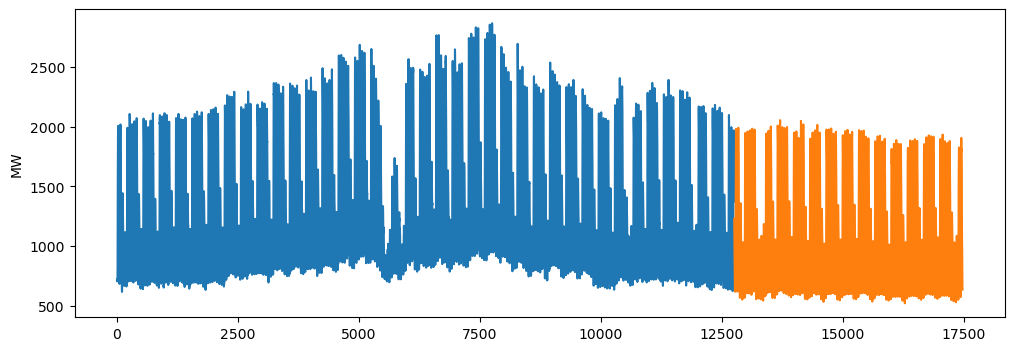

In [24]:
#Plot train and test
ax = train["Total Parameter"].plot(figsize=(12, 4), color="tab:blue")
_ = test["Total Parameter"].plot(ax=ax, color="tab:orange", ylabel="MW")

In [25]:
#Create XGBoost model with 1000 trees and maximum depth of 6
#XGBoost model with early stop if the model hasn't improved after 100 runs
#Learning rate of 0.3 and importance type used is weight
model = XGBRegressor(
    max_depth=6 
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 
    ,eta=0.3 
    ,importance_type='weight'
)
model.fit(
    X_train
    ,y_train
    ,eval_set=[(X_train, y_train)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 
)
X_test['Parameter Prediction'] = model.predict(X_test)


[0]	validation_0-mae:912.63399
[1]	validation_0-mae:639.95795
[2]	validation_0-mae:452.52694
[3]	validation_0-mae:322.73225
[4]	validation_0-mae:231.84549
[5]	validation_0-mae:169.44947
[6]	validation_0-mae:127.36884
[7]	validation_0-mae:98.00970
[8]	validation_0-mae:78.56360
[9]	validation_0-mae:66.16847
[10]	validation_0-mae:59.45958
[11]	validation_0-mae:53.79081
[12]	validation_0-mae:50.34751
[13]	validation_0-mae:45.55385
[14]	validation_0-mae:43.21226
[15]	validation_0-mae:41.56586
[16]	validation_0-mae:40.46980
[17]	validation_0-mae:38.72195
[18]	validation_0-mae:37.45106
[19]	validation_0-mae:36.45032
[20]	validation_0-mae:35.27040
[21]	validation_0-mae:34.43223
[22]	validation_0-mae:33.18293
[23]	validation_0-mae:32.48243
[24]	validation_0-mae:31.55502
[25]	validation_0-mae:30.81817
[26]	validation_0-mae:30.30731
[27]	validation_0-mae:29.90424
[28]	validation_0-mae:29.52820
[29]	validation_0-mae:29.15750
[30]	validation_0-mae:28.72985
[31]	validation_0-mae:28.32728
[32]	valida

C:\Users\nanan\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\nanan\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-mae:26.68709
[36]	validation_0-mae:26.47296
[37]	validation_0-mae:26.29605
[38]	validation_0-mae:25.93255
[39]	validation_0-mae:25.47014
[40]	validation_0-mae:25.20116
[41]	validation_0-mae:24.88674
[42]	validation_0-mae:24.72039
[43]	validation_0-mae:24.38391
[44]	validation_0-mae:23.99942
[45]	validation_0-mae:23.43618
[46]	validation_0-mae:23.07283
[47]	validation_0-mae:22.80676
[48]	validation_0-mae:22.65321
[49]	validation_0-mae:22.51478
[50]	validation_0-mae:22.35174
[51]	validation_0-mae:22.22945
[52]	validation_0-mae:22.07265
[53]	validation_0-mae:21.85954
[54]	validation_0-mae:21.75625
[55]	validation_0-mae:21.53391
[56]	validation_0-mae:21.09796
[57]	validation_0-mae:20.97443
[58]	validation_0-mae:20.68779
[59]	validation_0-mae:20.53381
[60]	validation_0-mae:20.45440
[61]	validation_0-mae:20.23485
[62]	validation_0-mae:20.11960
[63]	validation_0-mae:19.88051
[64]	validation_0-mae:19.78224
[65]	validation_0-mae:19.58352
[66]	validation_0-mae:19.45689
[67]	val

[296]	validation_0-mae:8.64979
[297]	validation_0-mae:8.64067
[298]	validation_0-mae:8.62342
[299]	validation_0-mae:8.61058
[300]	validation_0-mae:8.60359
[301]	validation_0-mae:8.59419
[302]	validation_0-mae:8.59276
[303]	validation_0-mae:8.57273
[304]	validation_0-mae:8.54742
[305]	validation_0-mae:8.49768
[306]	validation_0-mae:8.48272
[307]	validation_0-mae:8.46819
[308]	validation_0-mae:8.45487
[309]	validation_0-mae:8.42533
[310]	validation_0-mae:8.41029
[311]	validation_0-mae:8.39666
[312]	validation_0-mae:8.39387
[313]	validation_0-mae:8.38839
[314]	validation_0-mae:8.36305
[315]	validation_0-mae:8.31141
[316]	validation_0-mae:8.29160
[317]	validation_0-mae:8.28622
[318]	validation_0-mae:8.25162
[319]	validation_0-mae:8.24570
[320]	validation_0-mae:8.22635
[321]	validation_0-mae:8.21576
[322]	validation_0-mae:8.20935
[323]	validation_0-mae:8.19737
[324]	validation_0-mae:8.17027
[325]	validation_0-mae:8.14782
[326]	validation_0-mae:8.14294
[327]	validation_0-mae:8.13458
[328]	va

[561]	validation_0-mae:5.88733
[562]	validation_0-mae:5.88079
[563]	validation_0-mae:5.87314
[564]	validation_0-mae:5.85103
[565]	validation_0-mae:5.84052
[566]	validation_0-mae:5.83320
[567]	validation_0-mae:5.83064
[568]	validation_0-mae:5.82921
[569]	validation_0-mae:5.82559
[570]	validation_0-mae:5.81405
[571]	validation_0-mae:5.79430
[572]	validation_0-mae:5.79146
[573]	validation_0-mae:5.78805
[574]	validation_0-mae:5.78611
[575]	validation_0-mae:5.77503
[576]	validation_0-mae:5.77207
[577]	validation_0-mae:5.76418
[578]	validation_0-mae:5.74866
[579]	validation_0-mae:5.72981
[580]	validation_0-mae:5.72495
[581]	validation_0-mae:5.71666
[582]	validation_0-mae:5.71256
[583]	validation_0-mae:5.70425
[584]	validation_0-mae:5.69101
[585]	validation_0-mae:5.68561
[586]	validation_0-mae:5.68281
[587]	validation_0-mae:5.67948
[588]	validation_0-mae:5.67768
[589]	validation_0-mae:5.66766
[590]	validation_0-mae:5.66483
[591]	validation_0-mae:5.66249
[592]	validation_0-mae:5.64860
[593]	va

[826]	validation_0-mae:4.58190
[827]	validation_0-mae:4.58032
[828]	validation_0-mae:4.57660
[829]	validation_0-mae:4.57409
[830]	validation_0-mae:4.57251
[831]	validation_0-mae:4.56466
[832]	validation_0-mae:4.55992
[833]	validation_0-mae:4.55744
[834]	validation_0-mae:4.55191
[835]	validation_0-mae:4.54820
[836]	validation_0-mae:4.54451
[837]	validation_0-mae:4.54195
[838]	validation_0-mae:4.53796
[839]	validation_0-mae:4.53524
[840]	validation_0-mae:4.53371
[841]	validation_0-mae:4.53111
[842]	validation_0-mae:4.53018
[843]	validation_0-mae:4.52807
[844]	validation_0-mae:4.52433
[845]	validation_0-mae:4.52255
[846]	validation_0-mae:4.52007
[847]	validation_0-mae:4.51605
[848]	validation_0-mae:4.51436
[849]	validation_0-mae:4.50843
[850]	validation_0-mae:4.50452
[851]	validation_0-mae:4.50190
[852]	validation_0-mae:4.49658
[853]	validation_0-mae:4.48658
[854]	validation_0-mae:4.48420
[855]	validation_0-mae:4.48143
[856]	validation_0-mae:4.47843
[857]	validation_0-mae:4.47433
[858]	va

In [26]:
#Assign the prediction values to a variable
y_pred = X_test["Parameter Prediction"]

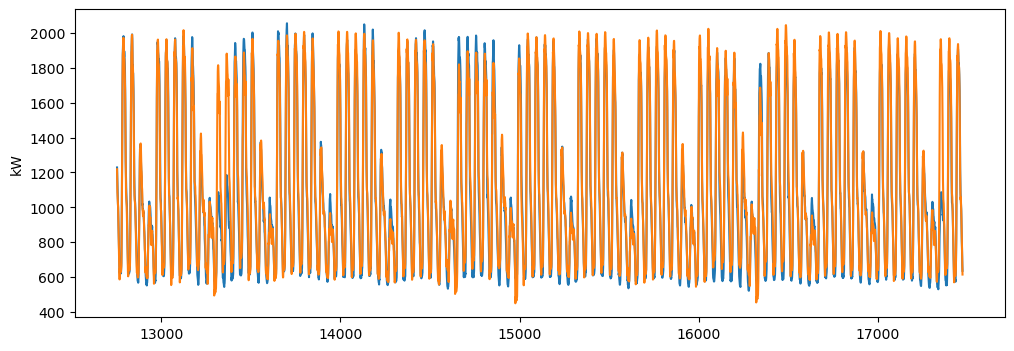

In [27]:
#Plot predictions against actual values
ax = y_test.plot(figsize=(12, 4), color="tab:blue")
_ = y_pred.plot(ax=ax, color="tab:orange", ylabel="kW")

### Model Metrics

In [28]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

100.60897710232081

In [29]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.9510421057877754

In [30]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE : {MAPE:.2f} %")

MAPE : 0.06 %


### Predictions

In [31]:
#Convert datetime_int into datetime type
X_test['datetime_int'] = pd.to_datetime(df['datetime_int'])

In [32]:
#Create Date column from datetime_int
X_test['Date'] = pd.to_datetime(X_test['datetime_int']).dt.date

In [33]:
#Drop Hour column and create new Hour column from datetime_int
X_test = X_test.drop(["Hour"], axis=1)
X_test['Hour'] = pd.to_datetime(X_test['datetime_int']).dt.time

In [34]:
#Create pivot table with predictions, date and hour
df_dailypeakloadtime = X_test.pivot_table(values='Parameter Prediction', index = 'Date', columns= 'Hour' ,aggfunc= 'max')

In [35]:
#Table with load value prediction by hour and date
df_dailypeakloadtime.head()

Hour,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1053.629639,1022.708069,998.182129,941.341492,881.889771,819.202148,782.013916,731.397522,670.315430,617.007263
2012-05-24,586.504822,593.563232,649.988647,636.179382,634.295837,634.116333,627.356323,630.579895,635.356506,647.752869,...,1054.771118,1023.146912,1000.463257,941.461426,888.071350,826.570129,781.516235,733.103149,674.303101,620.595459
2012-05-25,604.431458,614.310364,664.969849,649.751587,646.904053,648.123901,638.864563,641.828613,643.921326,656.870422,...,1027.700073,1002.871460,984.426697,936.635742,882.311279,825.179077,790.737244,753.292664,707.136719,660.656189
2012-05-26,634.772339,624.010559,655.333557,634.621338,613.427124,606.112732,597.557678,606.028870,606.379639,615.562073,...,964.244080,951.451721,925.149475,870.852173,861.885803,819.411438,801.643555,762.318115,712.562439,665.524414
2012-05-27,625.360962,624.584473,658.709595,631.861267,620.345398,611.883789,605.950745,599.984802,598.716553,608.033936,...,865.147705,839.462585,816.694641,783.963379,771.681519,752.502991,727.215210,678.536255,632.224365,584.023254


In [36]:
#Find peak load times per day
df_dailypeakloadtime.idxmax(axis=1)

Date
2012-05-23    17:00:00
2012-05-24    10:30:00
2012-05-25    11:00:00
2012-05-26    11:00:00
2012-05-27    11:30:00
                ...   
2012-08-25    11:00:00
2012-08-26    11:30:00
2012-08-27    11:00:00
2012-08-28    11:00:00
2012-08-29    11:00:00
Length: 99, dtype: object

In [37]:
#Find peak load values per day
df_dailypeakloadtime.max(axis=1)

Date
2012-05-23    1218.149780
2012-05-24    1971.713867
2012-05-25    1989.360229
2012-05-26    1365.983765
2012-05-27    1010.024963
                 ...     
2012-08-25    1324.771851
2012-08-26     984.858276
2012-08-27    1963.341431
2012-08-28    1969.032349
2012-08-29    1935.630737
Length: 99, dtype: float32

<Axes: >

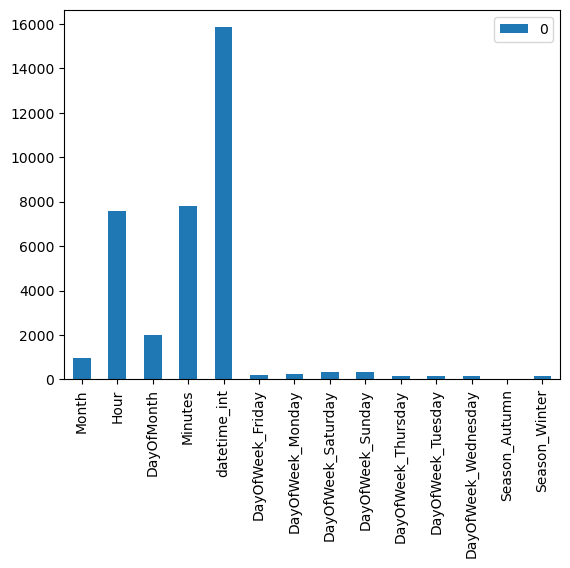

In [38]:
#Calculate feature importance
f_importance = model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.plot.bar()

### Predict day ahead

In [39]:
#Run model for day ahead dataframe
dfprediction = dfprediction.drop(columns= ["Date and Time of capture","Total Parameter"], axis=1)
dfprediction['Parameter Prediction'] = model.predict(dfprediction)

In [40]:
#Convert datetime_int to datetime and create Date and Hour columns
dfprediction['datetime_int'] = pd.to_datetime(dfprediction['datetime_int'])
dfprediction['Date'] = pd.to_datetime(dfprediction['datetime_int']).dt.date
dfprediction = dfprediction.drop(["Hour"], axis=1)
dfprediction['Hour'] = pd.to_datetime(dfprediction['datetime_int']).dt.time

In [41]:
dfprediction.head()

,Month,Year,Quarter,DayOfMonth,Minutes,datetime_int,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Parameter Prediction,Date,Hour
17472,8,2012,3,30,0,2012-08-30 00:00:00,0,0,0,0,1,0,0,0,0,1,0,577.044373,2012-08-30,00:00:00
17473,8,2012,3,30,30,2012-08-30 00:30:00,0,0,0,0,1,0,0,0,0,1,0,583.519653,2012-08-30,00:30:00
17474,8,2012,3,30,60,2012-08-30 01:00:00,0,0,0,0,1,0,0,0,0,1,0,647.377930,2012-08-30,01:00:00
17475,8,2012,3,30,90,2012-08-30 01:30:00,0,0,0,0,1,0,0,0,0,1,0,633.799133,2012-08-30,01:30:00
17476,8,2012,3,30,120,2012-08-30 02:00:00,0,0,0,0,1,0,0,0,0,1,0,631.915466,2012-08-30,02:00:00


In [42]:
#Table with load value prediction by hour and date
df_dailypeakloadtime = dfprediction.pivot_table(values='Parameter Prediction', index = 'Date', columns= 'Hour' ,aggfunc= 'max')

In [43]:
df_dailypeakloadtime

Hour,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-30,577.044373,583.519653,647.37793,633.799133,631.915466,631.736084,624.835327,626.947632,629.007996,640.78125,...,1059.802734,1029.193848,1007.036682,952.214966,896.760376,834.170898,791.580994,743.898987,691.071045,632.03717


In [44]:
#Find peak load time
df_dailypeakloadtime.idxmax(axis=1)

Date
2012-08-30    10:30:00
dtype: object

In [45]:
#Find peak load value
df_dailypeakloadtime.max(axis=1)

Date
2012-08-30    1969.070312
dtype: float32

In [46]:
#Assign prediction values to dataframe
daily_pred = dfprediction["Parameter Prediction"]

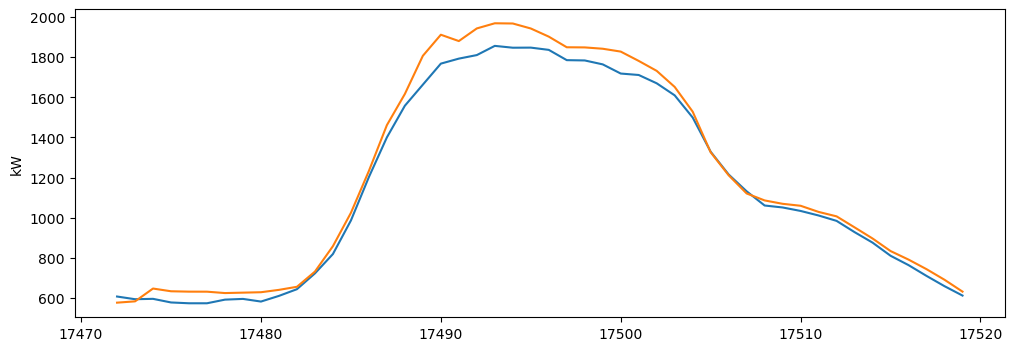

In [47]:
#Plot prediction against actual values
ax = daily_test.plot(figsize=(12, 4), color="tab:blue")
_ = daily_pred.plot(ax=ax, color="tab:orange", ylabel="kW")
plt.savefig('XGB.png')